# Code to test before run on hpcc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision

import h5py
import os

from H5Dataset import H5Dataset
from CNNModels import *
from CNNTrain import *

In [2]:
np.random.seed(0) # set seed for reproduceability
test_number = 2
epoch0 = 2
epoch1 = 5
epoch2 = 1

In [3]:
# Make a function to get data from a list of files
hdf5_dir = "/mnt/scratch/tranant2/2022_11_21_data"
files = os.listdir(hdf5_dir)
hdf5_files1 = [(hdf5_dir + '/'+i) for i in files ]

In [4]:
for file in hdf5_files1:
    print(file)

/mnt/scratch/tranant2/2022_11_21_data/data_0.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_2.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_3.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_1.hdf5


In [5]:
dataset = H5Dataset(hdf5_files1[0:1], transform=False)

20
(20, 33, 33, 6)
Added first file, current memory of dataset: 0.002406537818020143


In [6]:
ntrain = int(dataset.__len__()*.8)
ntest = dataset.__len__() - ntrain

In [7]:
train_set, test_set = torch.utils.data.random_split(dataset,[ntrain,ntest])
train_loader = DataLoader(dataset=train_set, batch_size = 1024, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size = 1024, shuffle=True)

### Make sure GPU is avaliable

In [8]:
print(f"Is GPU avaliable: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Got the: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/(1028**3)} GB")

Is GPU avaliable: True
Got the: Tesla K80
Total memory: 11.781983108519892 GB


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation will be happening on the {device}")

Computation will be happening on the cuda:0


## Train 1

In [10]:
learning_rate = 0.001

model = VAE().to(device)

In [11]:
# Code to get params
params = model.state_dict()
keys = list(params.keys())
for key in keys[-6:]:
    print(key)

Loss0.weight
Loss0.bias
Loss1.weight
Loss1.bias
Loss2.weight
Loss2.bias


In [12]:
# Code to remove require grad
for name, param in model.named_parameters():
    if name in keys[-6:] and param.requires_grad:
        param.requires_grad = False

In [13]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=learning_rate,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.001,
                       amsgrad=False,)

In [14]:
n_epochs = epoch0
train_losses, counter = train_model(model, n_epochs, train_loader, optimizer, device = device)

Train Epoch: 0 [0/16 (0%)]	Loss: 3114.239014
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1257.36083984375, distro1:996.913818359375, distro2:533.0587158203125, distro3:256.72918701171875, distro4:70.17635345458984
Train Epoch: 1 [0/16 (0%)]	Loss: 3018.123779
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1188.6995849609375, distro1:976.7533569335938, distro2:527.810546875, distro3:255.04124450683594, distro4:69.81916809082031


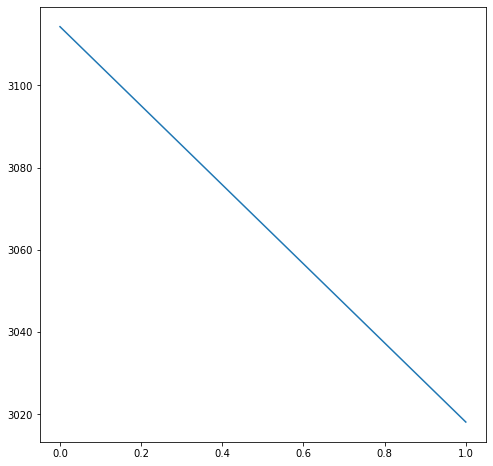

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/loss_{test_number}.png", dpi = 100)

In [16]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

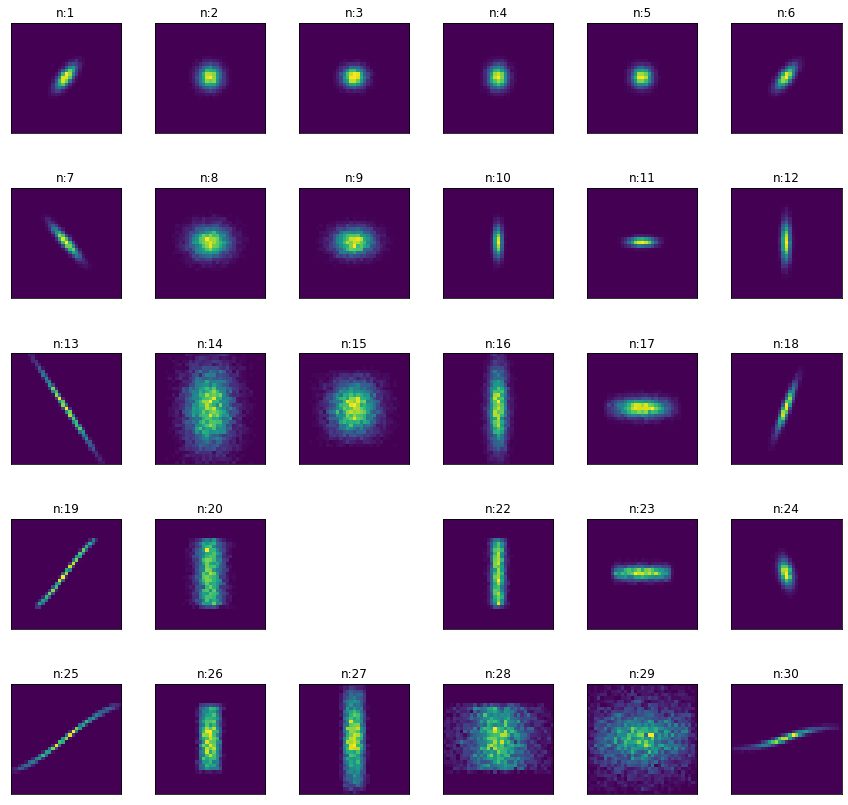

In [17]:
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(test_data[j+1])[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/OriginalPhaseSpace_{test_number}.png", dpi = 100)

loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1600.0771484375, distro1:1452.9520263671875, distro2:974.9735107421875, distro3:786.3845825195312, distro4:649.80908203125


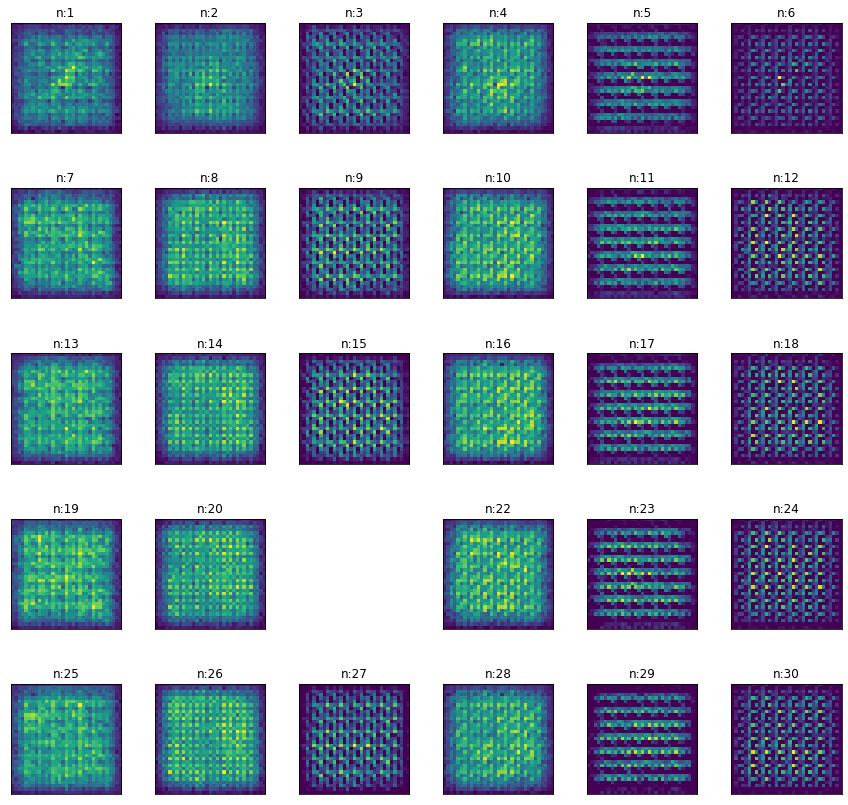

In [19]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
#loss0 = nn.MSELoss()(output_0, losses[0])
#loss1 = nn.MSELoss()(output_1, losses[1])
#loss2 = nn.MSELoss()(output_2, losses[2])
#loss3 = nn.MSELoss()(output_3, losses[3])
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{0},loss1:{0}, loss2:{0}, loss3:{0},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")
    
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/ReconstructedPhaseSpace_{test_number}.png", dpi = 100)

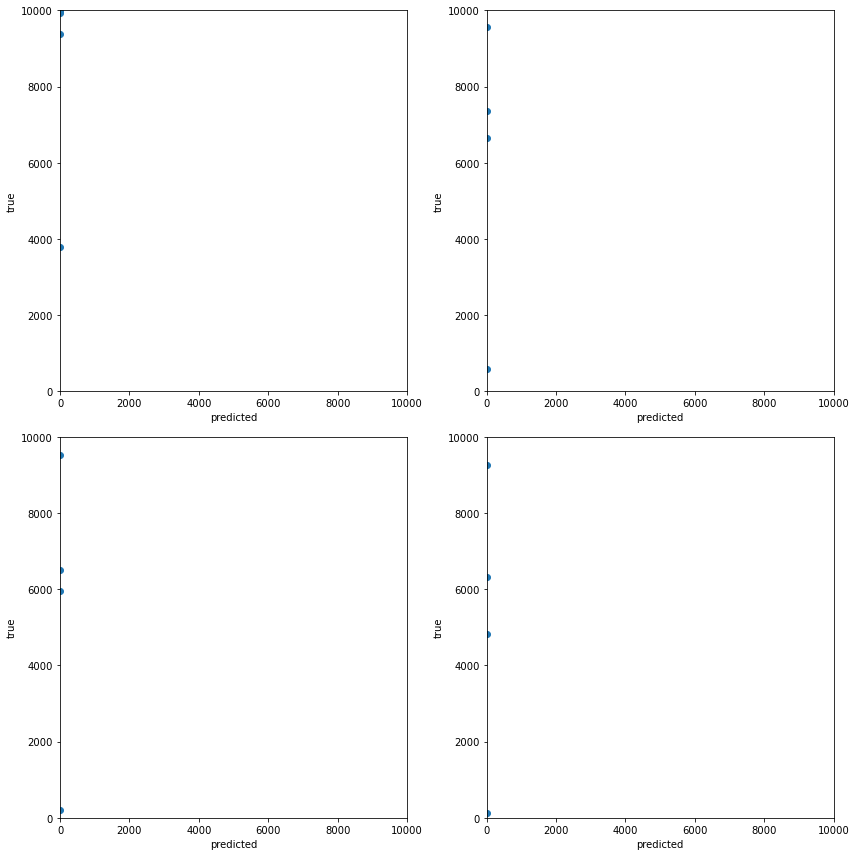

In [20]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_{test_number}.png", dpi = 100)

In [21]:
torch.save(model.state_dict(), f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model_{test_number}.pth")

## Train 2

In [22]:
print("On to state 2 of training. Training the loss function")

On to state 2 of training. Training the loss function


In [23]:
model.load_state_dict(torch.load( f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model_{test_number}.pth"), strict=False)

<All keys matched successfully>

In [24]:
# Code to get params
params = model.state_dict()
keys = list(params.keys())
for key in keys[:-6]:
    print(key)

encoders.0.c2d1.weight
encoders.0.c2d1.bias
encoders.0.c2d2.weight
encoders.0.c2d2.bias
encoders.0.linear1.weight
encoders.0.linear1.bias
encoders.1.c2d1.weight
encoders.1.c2d1.bias
encoders.1.c2d2.weight
encoders.1.c2d2.bias
encoders.1.linear1.weight
encoders.1.linear1.bias
encoders.2.c2d1.weight
encoders.2.c2d1.bias
encoders.2.c2d2.weight
encoders.2.c2d2.bias
encoders.2.linear1.weight
encoders.2.linear1.bias
encoders.3.c2d1.weight
encoders.3.c2d1.bias
encoders.3.c2d2.weight
encoders.3.c2d2.bias
encoders.3.linear1.weight
encoders.3.linear1.bias
encoders.4.c2d1.weight
encoders.4.c2d1.bias
encoders.4.c2d2.weight
encoders.4.c2d2.bias
encoders.4.linear1.weight
encoders.4.linear1.bias
encoders.5.c2d1.weight
encoders.5.c2d1.bias
encoders.5.c2d2.weight
encoders.5.c2d2.bias
encoders.5.linear1.weight
encoders.5.linear1.bias
decoders.0.linear2.weight
decoders.0.linear2.bias
decoders.0.ct2d1.weight
decoders.0.ct2d1.bias
decoders.0.ct2d2.weight
decoders.0.ct2d2.bias
decoders.0.ct2d3.weight
decode

In [25]:
# Code add back gradient
for name, param in model.named_parameters():
    if not param.requires_grad:
        param.requires_grad = True
        
# Code to remove remove gradient from auto-encoder
for name, param in model.named_parameters():
    if name in keys[:-6] and param.requires_grad:
        param.requires_grad = False

In [26]:
optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=.01,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.000,
                       amsgrad=False,)

In [27]:
n_epochs = epoch1
train_losses, counter = train_model2(model, n_epochs, train_loader, optimizer2, device=device)

Train Epoch: 0 [0/16 (0%)]	Loss: 16609.234375
loss0:7862.48388671875,loss1:4383.75, loss2:2555.6875, loss3:1807.3125
Train Epoch: 1 [0/16 (0%)]	Loss: 16434.220703
loss0:7741.86328125,loss1:4356.4951171875, loss2:2537.052734375, loss3:1798.8095703125
Train Epoch: 2 [0/16 (0%)]	Loss: 15881.386719
loss0:7423.5625,loss1:4232.84375, loss2:2460.2578125, loss3:1764.72265625
Train Epoch: 3 [0/16 (0%)]	Loss: 14660.207031
loss0:6762.9375,loss1:3933.96875, loss2:2279.921875, loss3:1683.37890625
Train Epoch: 4 [0/16 (0%)]	Loss: 12459.914062
loss0:5581.3125,loss1:3369.03125, loss2:1974.9375, loss3:1534.6328125


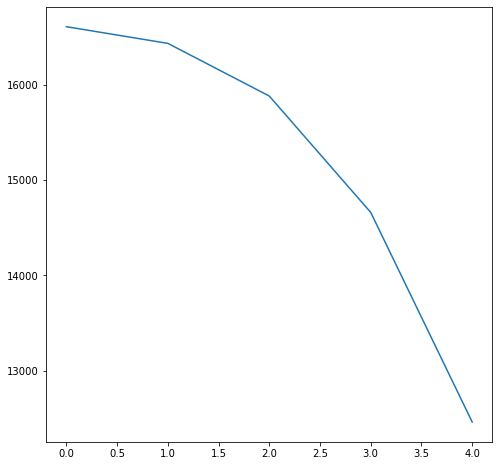

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/loss_{test_number}_2.png", dpi = 100)

In [29]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

loss0:37909.91015625,loss1:45439.44140625, loss2:47065.3671875, loss3:47436.0859375,
 distro0:0, distro1:0, distro2:0, distro3:0, distro4:0


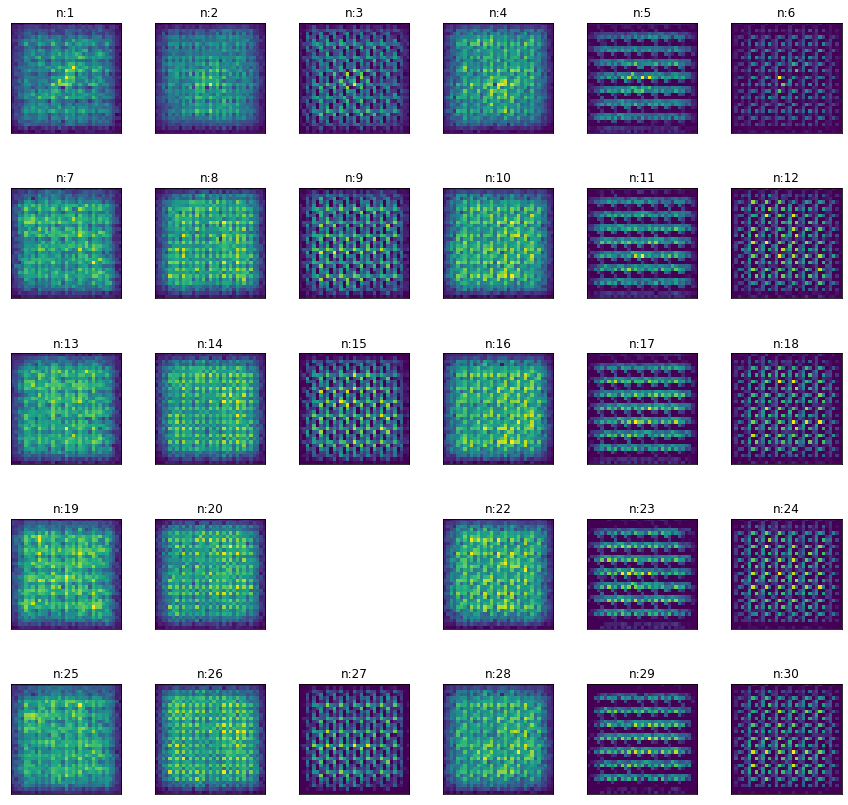

In [31]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
loss0 = nn.HuberLoss(reduction='mean', delta=10.0)(output_0, losses[0])
loss1 = nn.HuberLoss(reduction='mean', delta=10.0)(output_1, losses[1])
loss2 = nn.HuberLoss(reduction='mean', delta=10.0)(output_2, losses[2])
loss3 = nn.HuberLoss(reduction='mean', delta=10.0)(output_3, losses[3])
print(f"loss0:{loss0},loss1:{loss1}, loss2:{loss2}, loss3:{loss3},\n distro0:{0}, distro1:{0}, distro2:{0}, distro3:{0}, distro4:{0}")
    
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/ReconstructedPhaseSpace_{test_number}_2.png", dpi = 100)

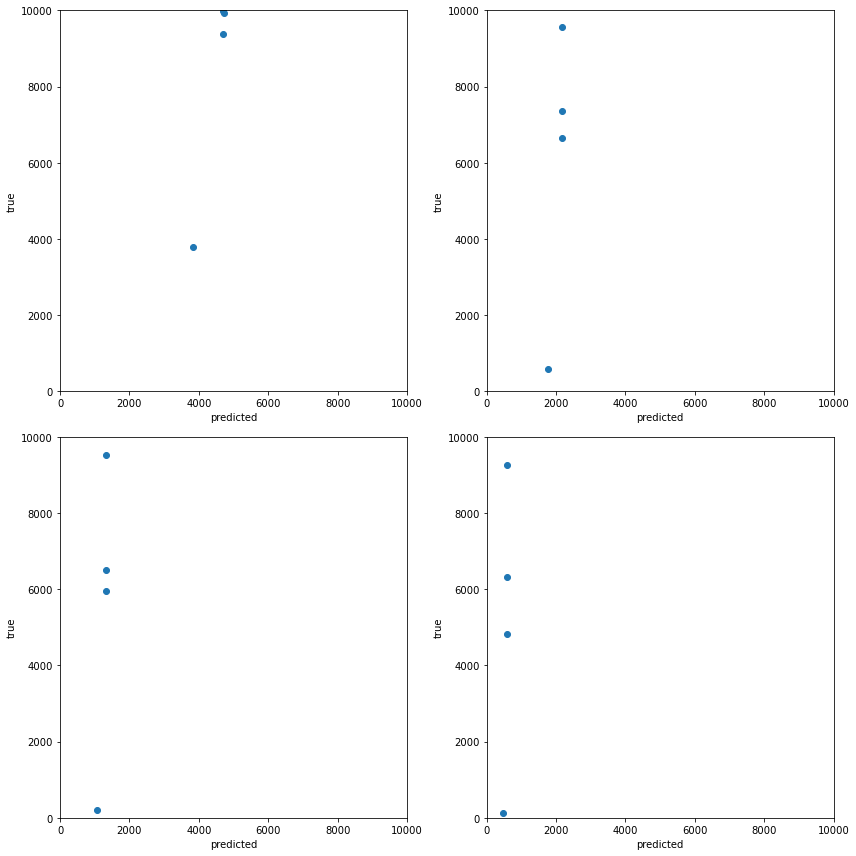

In [32]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_{test_number}_2.png", dpi = 100)

In [33]:
torch.save(model.state_dict(), f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model__{test_number}.pth")

## Train 3

In [34]:
print("Finally, on to training 3: To fine tune things. Makue sure no overtraining")

Finally, on to training 3: To fine tune things. Makue sure no overtraining


In [35]:
model.load_state_dict(torch.load( f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model_{test_number}.pth"), strict=False)

<All keys matched successfully>

In [36]:
# Code add back gradient
for name, param in model.named_parameters():
    if not param.requires_grad:
        param.requires_grad = True

In [37]:
optimizer3 = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=0.001,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.000,
                       amsgrad=False,)

In [38]:
n_epochs = epoch2
train_losses, counter = train_model3(model, n_epochs, train_loader, optimizer3, device=device)

Train Epoch: 0 [0/16 (0%)]	Loss: 19498.998047
loss0:7862.48388671875,loss1:4383.75, loss2:2555.6875, loss3:1807.3125,
 distro0:1144.59521484375, distro1:921.0820922851562, distro2:507.2647399902344, distro3:248.3841094970703, distro4:68.4374771118164


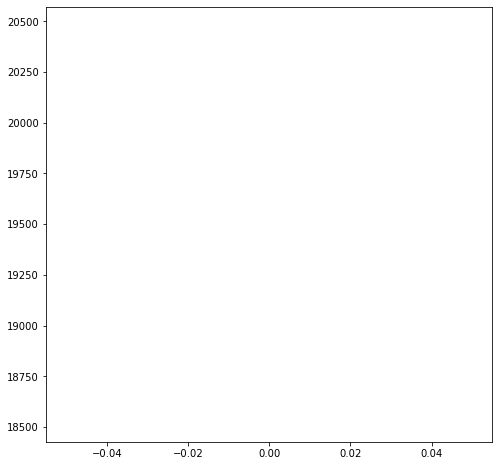

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/loss_{test_number}_3.png", dpi = 100)

In [40]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

loss0:82481.71875,loss1:60267.703125, loss2:55447.17578125, loss3:51373.85546875,
 distro0:1502.4505615234375, distro1:1406.7117919921875, distro2:951.741943359375, distro3:771.0755004882812, distro4:641.8856201171875


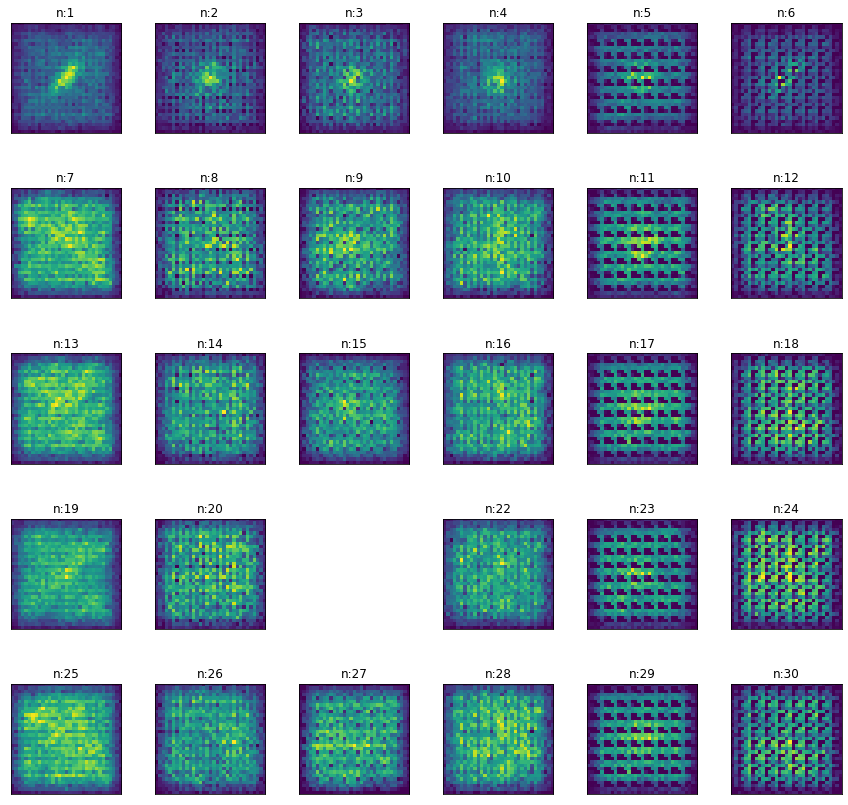

In [42]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
loss0 = nn.HuberLoss(reduction='mean', delta=10.0)(output_0, losses[0])
loss1 = nn.HuberLoss(reduction='mean', delta=10.0)(output_1, losses[1])
loss2 = nn.HuberLoss(reduction='mean', delta=10.0)(output_2, losses[2])
loss3 = nn.HuberLoss(reduction='mean', delta=10.0)(output_3, losses[3])
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{loss0},loss1:{loss1}, loss2:{loss2}, loss3:{loss3},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")

fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/ReconstructedPhaseSpace_{test_number}_3.png", dpi = 100)

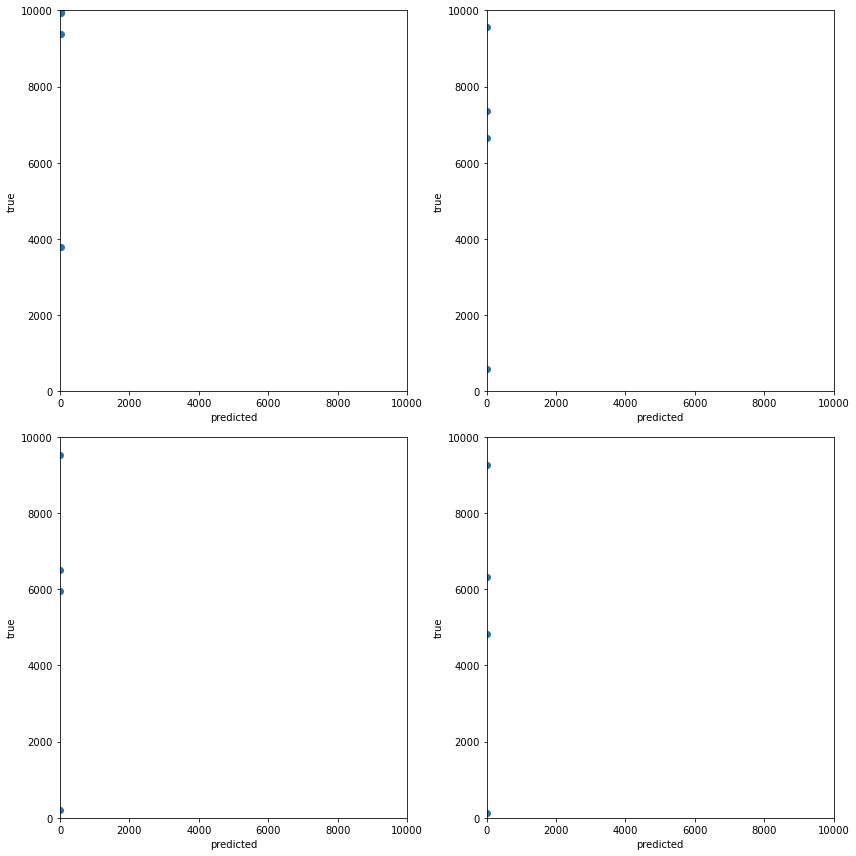

In [43]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_{test_number}_3.png", dpi = 100)

In [44]:
torch.save(model.state_dict(), f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model___{test_number}_3.pth")